<a href="https://colab.research.google.com/github/josvalen/practicetemp/blob/how-do-i-do-this/hellotutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# sklearn (for machine learning)
from sklearn.model_selection import train_test_split
from sklearn import metrics

# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'notebook')

In [ ]:
version = 'pristine'

file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))


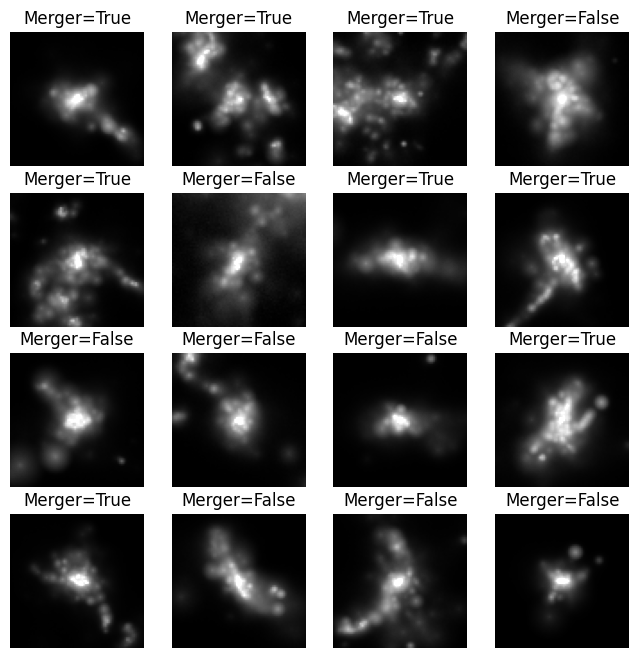

In [ ]:
# set the random seed to get the same random set of images each time, or comment it out to get different ones!
#np.random.seed(206265)

# select 16 random image indices:
example_ids = np.random.choice(hdu[1].data.shape[0], 16)
# pull the F160W image (index=1) from the simulated dataset for these selections
examples = [hdu[0].data[j, 1, :, :] for j in example_ids]

# initialize your figure
fig = plt.figure(figsize=(8, 8))

# loop through the randomly selected images and plot with labels
for i, image in enumerate(examples):
    ax = fig.add_subplot(4, 4, i+1)
    norm = simple_norm(image, 'log', max_percent=99.75)

    ax.imshow(image, aspect='equal', cmap='binary_r', norm=norm)
    ax.set_title('Merger='+str(bool(hdu[1].data[example_ids[i]][0])))

    ax.axis('off')

plt.show()

In [ ]:
X = hdu[0].data
y = hdu[1].data

In [ ]:
# as above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!
random_state = 50

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [ ]:
imsize = np.shape(X_train)[2]

X_train = X_train.reshape(-1, imsize, imsize, 3)
X_valid = X_valid.reshape(-1, imsize, imsize, 3)
X_test = X_test.reshape(-1, imsize, imsize, 3)

In [ ]:
# ------------------------------------------------------------------------------
# generate the model architecture
# Written for Keras 2
# ------------------------------------------------------------------------------

# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

In [ ]:
# Compile Model
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)
cnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 8)         608       
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 8)        32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 37, 37, 8)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 37, 37, 8)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 37, 37, 16)        1168

In [ ]:
nb_epoch = 50
batch_size = 128
shuffle = True

# Train
history = cnn.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=nb_epoch,
                  validation_data=(X_valid, y_valid),
                  shuffle=shuffle,
                  verbose=False)

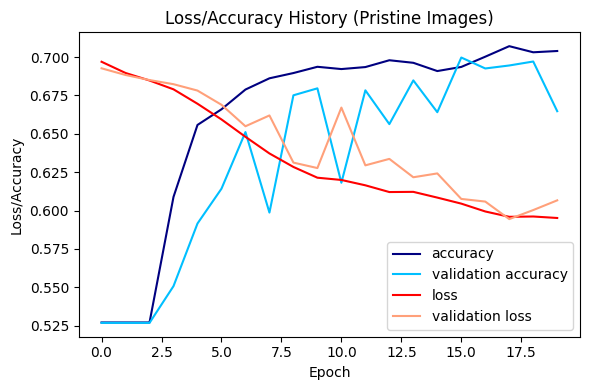

In [ ]:
# plotting from history

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))

figsize = (6, 4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")


plots = plot1_loss + plot1_val_loss
labs = [plot.get_label() for plot in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History (Pristine Images)")
plt.tight_layout()
axis1.legend(loc='lower right')
plt.show()

In [ ]:
test_predictions = cnn.predict(X_test)

97/97 [==============================] - 5s 45ms/step


In [ ]:
def plot_confusion_matrix(cnn, input_data, input_labels):

    # Compute merger predictions for the test dataset
    predictions = cnn.predict(input_data)

    # Convert to binary classification
    predictions = (predictions > 0.5).astype('int32')

    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1])
    cm = cm.astype('float')

    # Normalize the confusion matrix results.
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]

    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.matshow(cm_norm, cmap='binary_r')

    plt.title('Confusion matrix', y=1.08)

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Merger', 'No Merger'])

    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Merger', 'No Merger'])

    plt.xlabel('Predicted')
    plt.ylabel('True')

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_norm[i, j] < thresh else "black")
    plt.show()

97/97 [==============================] - 4s 39ms/step


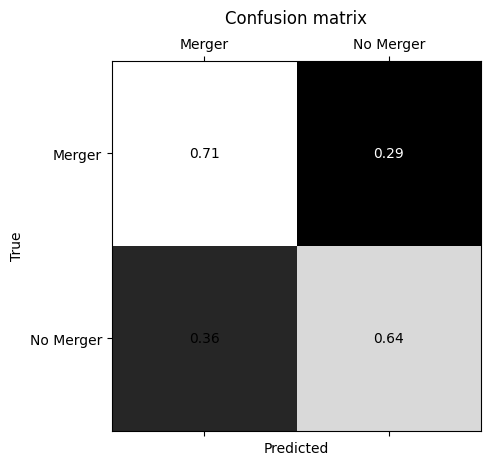

In [ ]:
plot_confusion_matrix(cnn, X_test, y_test)